# Fluorescence intensity detection and identification system

Using OpenCV to detect fluorescence intensity which emulates SYBR Green fluorescence from multiple color jpeg images. Data is parsed from HTTP POST requests by ESP32-CAM with OV2640 sensor.

In [2]:
# import os
# os.environ['QT_QPA_PLATFORM'] = 'xcb'

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def extract_g_channel(bgr_image):
    """
    Extract the G (green) channel from a BGR image and return it as a grayscale image.
    
    Parameters:
        bgr_image: Input BGR image (numpy array from cv.imread())
    
    Returns:
        g_channel: Single-channel grayscale image containing only the green channel data
    """

    g_channel = bgr_image[:, :, 1]

    return g_channel

## 1. Test camera noise by getting average pixel value of a blank image

Get image from box_wb_off

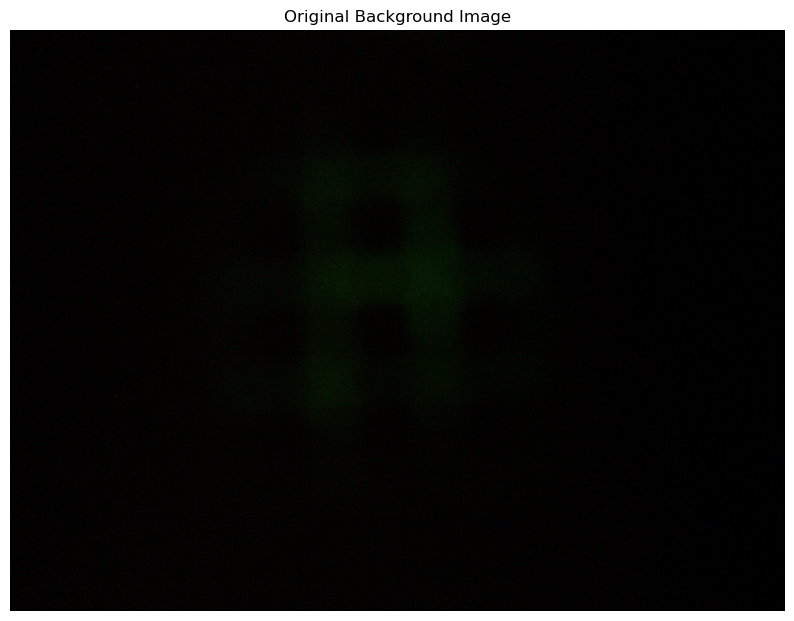

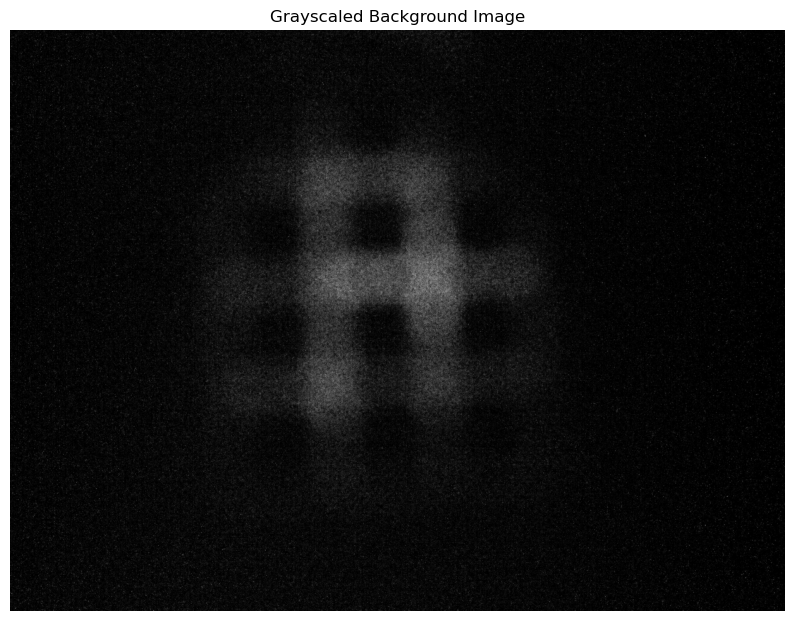

In [4]:
img = cv.imread('../AwbOff470/img_full_bg.jpg')
# gray1 = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray1 = extract_g_channel(img)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title('Original Background Image')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(gray1, cmap='gray')
plt.title('Grayscaled Background Image')
plt.axis('off')
plt.show()

Average all pixels in the image and print out the 8-bit value.

Overall average pixel value: 2.95

Image dimensions: 2592 x 1944
Section size: 648 x 648
\Sectioned image analysis:
Min section average: 0.89
Max section average: 7.87
Standard deviation across sections: 2.21


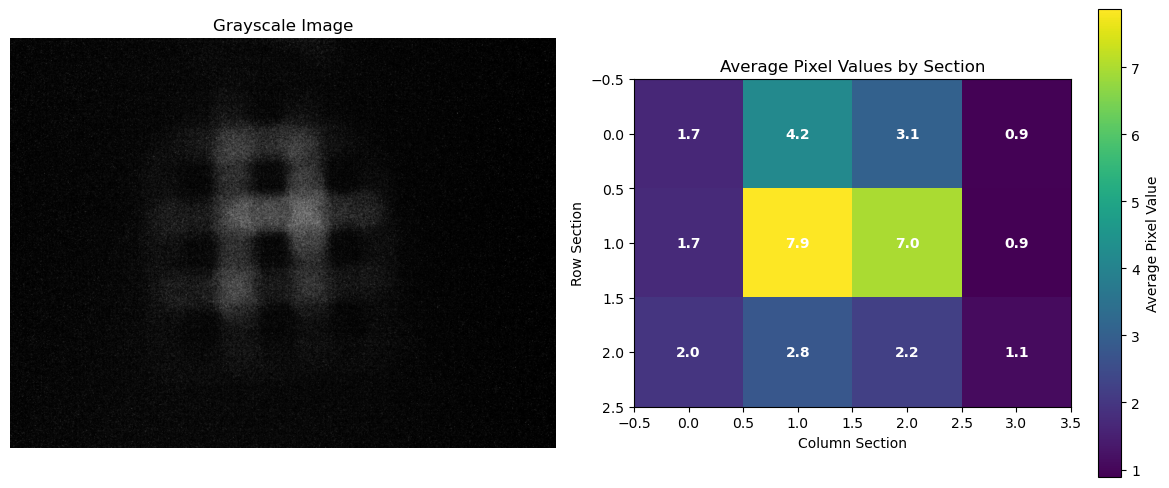

In [5]:
# Convert to grayscale for noise analysis
# gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = extract_g_channel(img)
# gray = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

def pixel_average_analysis(gray, section_rows=3, section_cols=4, static_row=None, static_col=None, verbose=True):
    if static_row is not None and static_col is not None:
        if static_row >= section_rows or static_col >= section_cols:
            raise ValueError("static_row and static_col must be within the range of section_rows and section_cols respectively.")
    # Calculate overall average
    overall_avg = np.mean(gray)
    if verbose:
        print(f"Overall average pixel value: {overall_avg:.2f}")

    # Divide image into sections
    height, width = gray.shape
    section_rows = section_rows
    section_cols = section_cols

    row_size = height // section_rows
    col_size = width // section_cols

    if verbose:
        print(f"\nImage dimensions: {width} x {height}")
        print(f"Section size: {col_size} x {row_size}")
    # print("\nAverage pixel values by section:")

    # Create a matrix to store section averages
    section_averages = np.zeros((section_rows, section_cols))

    for i in range(section_rows):
        for j in range(section_cols):
            # Calculate section boundaries
            start_row = i * row_size
            end_row = (i + 1) * row_size if i < section_rows - 1 else height
            start_col = j * col_size
            end_col = (j + 1) * col_size if j < section_cols - 1 else width
            
            # Extract section
            section = gray[start_row:end_row, start_col:end_col]
            
            # Calculate average for this section
            section_avg = np.mean(section)
            section_averages[i, j] = section_avg
            
            # print(f"Section [{i+1},{j+1}]: {section_avg:.2f}")

    # Display statistics
    if verbose:
        print(f"\Sectioned image analysis:")
        print(f"Min section average: {np.min(section_averages):.2f}")
        print(f"Max section average: {np.max(section_averages):.2f}")
        print(f"Standard deviation across sections: {np.std(section_averages):.2f}")

    # Visualize the section averages as a heatmap
    if verbose:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap='gray')
        plt.title('Grayscale Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(section_averages, cmap='viridis', interpolation='nearest')
        plt.title('Average Pixel Values by Section')
        plt.colorbar(label='Average Pixel Value')
        plt.xlabel('Column Section')
        plt.ylabel('Row Section')

        # Add text annotations to show values
        for i in range(section_rows):
            for j in range(section_cols):
                plt.text(j, i, f'{section_averages[i,j]:.1f}', 
                        ha='center', va='center', color='white', fontweight='bold')

        plt.tight_layout()
        
        plt.show()

    return overall_avg, np.max(section_averages), np.min(section_averages), section_averages[static_row, static_col] if static_row is not None and static_col is not None else None

avgg, maxg, _, _ = pixel_average_analysis(gray, section_rows=3, section_cols=4)

Image has background noise. Background will be subtracted from fluorescence image.

In [6]:
background_model = gray.copy().astype(np.float32)

def subtract_background(image, background):
    # Ensure both are float32 for proper subtraction
    img_float = image.astype(np.float32)
    bg_float = background.astype(np.float32)
    
    # Subtract background and clip to valid range
    result = np.clip(img_float - bg_float, 0, 255)
    return result.astype(np.uint8)

## 2. Image segmentation to focus on ROI

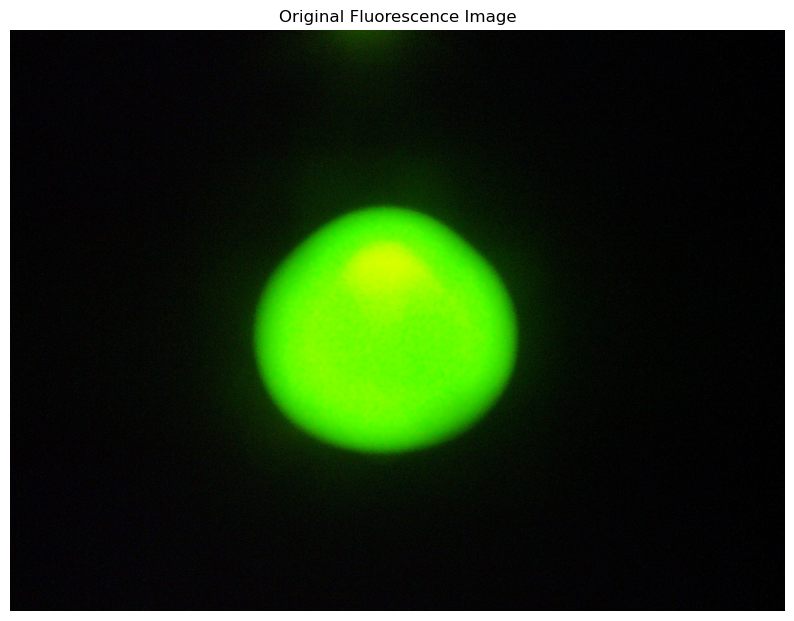

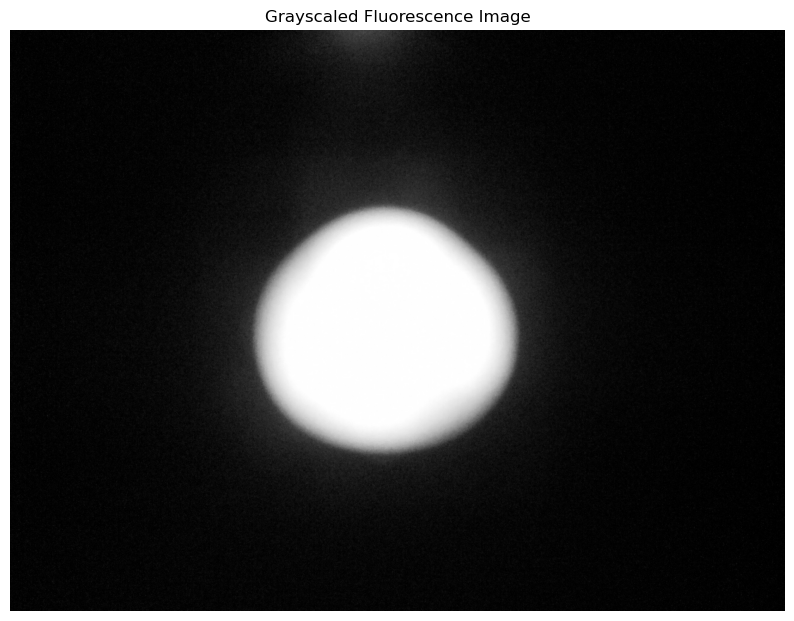

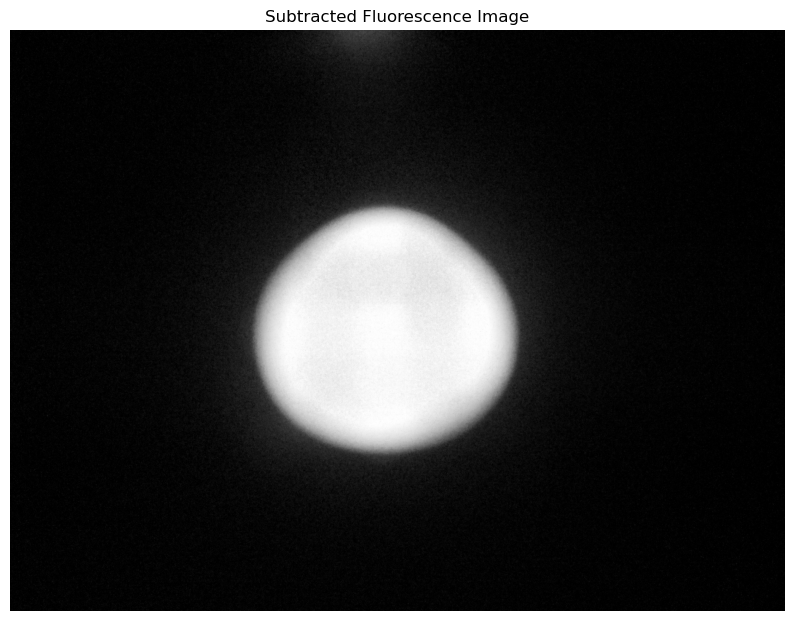

Overall average pixel value: 31.48

Image dimensions: 2592 x 1944
Section size: 324 x 324
\Sectioned image analysis:
Min section average: 1.59
Max section average: 244.58
Standard deviation across sections: 63.11


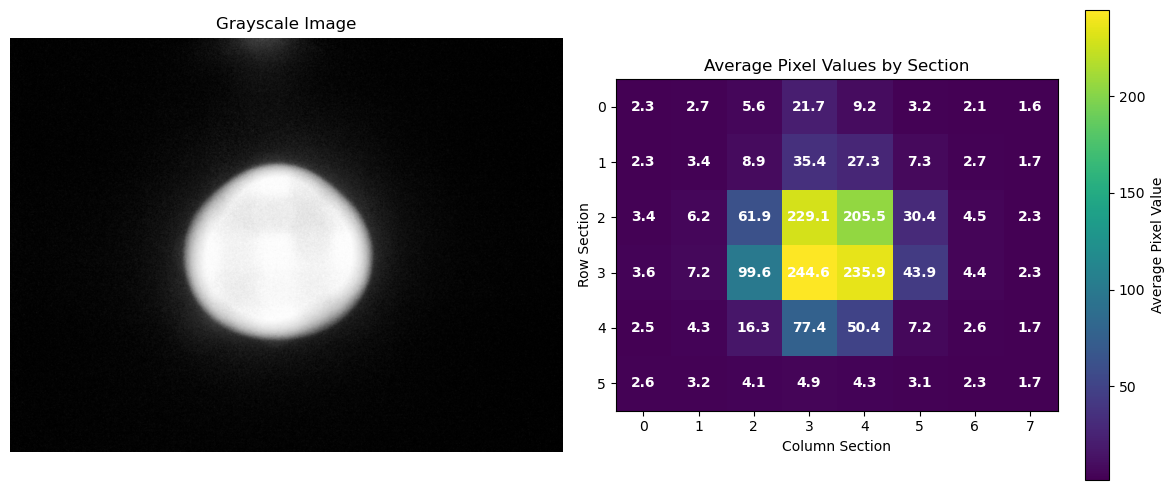

(np.float64(31.478768162881675),
 np.float64(244.5819996951684),
 np.float64(1.5855719402530102),
 None)

In [7]:
fluo = cv.imread('../AwbOff470/img_full_0000.jpg')
plt.figure(figsize=(10, 8))
plt.imshow(fluo)
plt.title('Original Fluorescence Image')
plt.axis('off')
plt.show()
# fluog = cv.cvtColor(fluo, cv.COLOR_BGR2GRAY)
fluog = extract_g_channel(fluo)
plt.figure(figsize=(10, 8))
plt.imshow(fluog, cmap='gray')
plt.title('Grayscaled Fluorescence Image')
plt.axis('off')
plt.show()

suback_fluog = subtract_background(fluog, background_model)
plt.figure(figsize=(10, 8))
plt.imshow(suback_fluog, cmap='gray')
plt.title('Subtracted Fluorescence Image')
plt.axis('off')
plt.show()

pixel_average_analysis(suback_fluog, section_rows=6, section_cols=8)

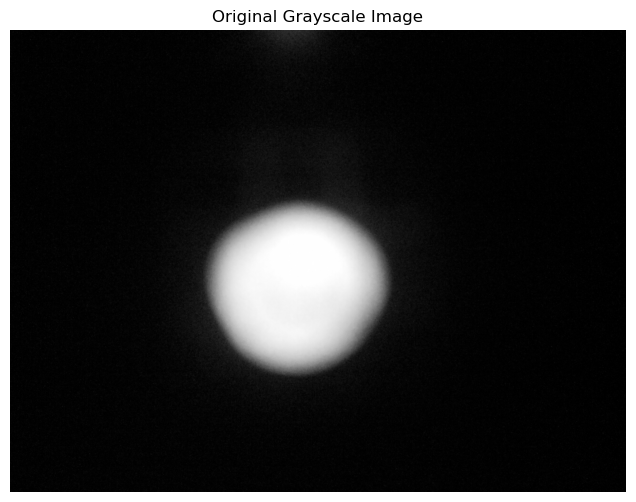

In [63]:
plt.figure(figsize=(8, 6))
plt.imshow(fluog, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')
plt.show()

In [64]:
def get_roi(fluo, suback_fluog, threshold_value=8, verbose=True):
    # Pixels brighter than 8 will become white (255), others black (0).
    threshold_value = threshold_value
    _, mask = cv.threshold(suback_fluog, threshold_value, 255, cv.THRESH_BINARY)

    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the largest contour by area
        largest_contour = max(contours, key=cv.contourArea)

        x, y, w, h = cv.boundingRect(largest_contour)
        cv.rectangle(fluo, (x, y), (x+w, y+h), (0, 0, 255), 2)

        if verbose:
            print(f"Found object with bounding box: x={x}, y={y}, width={w}, height={h}")
    else:
        if verbose:
            print("No object found meeting the threshold criteria.")

    if verbose:
        plt.figure(figsize=(15, 5))

        # Original image with ROI marked
        plt.subplot(1, 3, 1)
        plt.imshow(cv.cvtColor(fluo, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
        plt.title('Original Image with ROI Marked')
        plt.axis('off')

        # Grayscale image
        plt.subplot(1, 3, 2)
        plt.imshow(suback_fluog, cmap='gray')
        plt.title('Subtracted Grayscale Image')
        plt.axis('off')

        # Mask from thresholding
        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask from Thresholding')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return x, y, w, h


Found object with bounding box: x=750, y=617, width=930, height=886


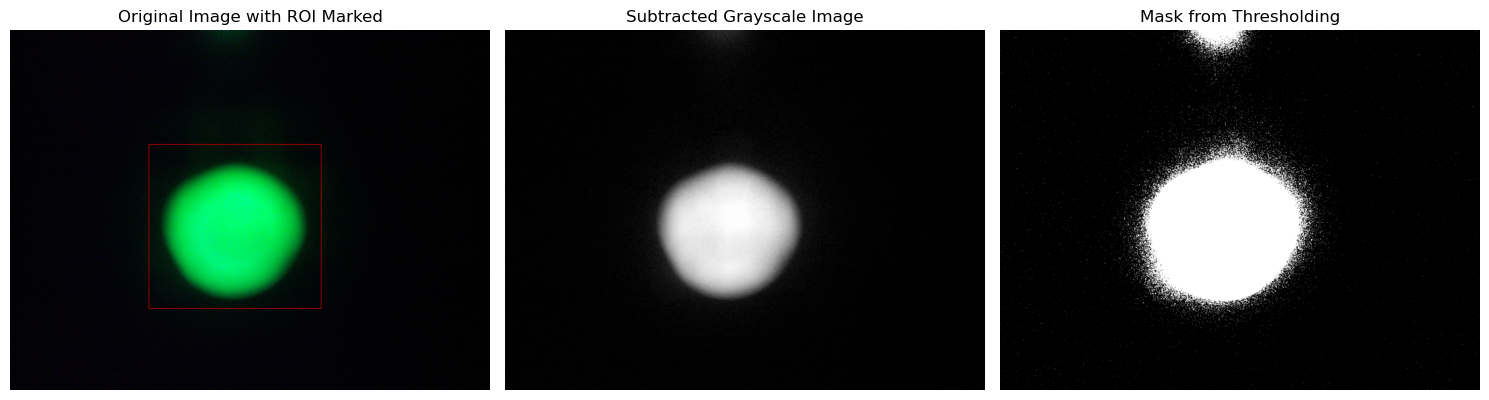

In [65]:

x, y, w, h = get_roi(fluo, suback_fluog, threshold_value=14)


Overall average pixel value: 19.56

Image dimensions: 2592 x 1944
ROI area: Row: 750:1680, Column: 617:1503
ROI size: 930 x 886
\Pixel analysis:
Average pixel value at ROI: 160.71
Standard deviation at ROI: 84.84


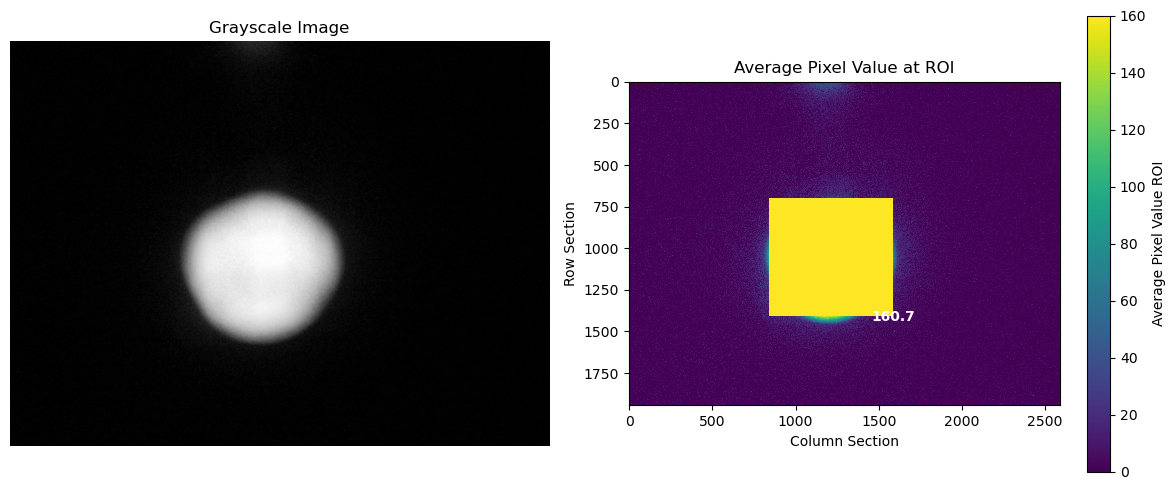

In [66]:
# Use a separate pixel analysis function for ROI images

def pixel_roi_analysis(gray, x, y, w, h, subset=1.0, verbose=True):
    # Calculate overall average
    overall_avg = np.mean(gray)
    if verbose:
        print(f"Overall average pixel value: {overall_avg:.2f}")

    height, width = gray.shape

    if verbose:
        print(f"\nImage dimensions: {width} x {height}")
        print(f"ROI area: Row: {x}:{x+w}, Column: {y}:{y+h}")
        print(f"ROI size: {w} x {h}")

    # Subset dictates percentage of innermost ROI pixels
    subset = subset     # Value between 0 and 1 (fraction of ROI pixels)
    if subset == 1:
        x = x
        y = y
        w = w
        h = h    
    else:
        half_w = w // 2
        add_x = int(half_w * (1 - subset))
        x = x + add_x
        w = int(w * subset)

        half_h = h // 2
        add_y = int(half_h * (1 - subset))
        y = y + add_y
        h = int(h * subset)

    roi_section = gray[y:y+h, x:x+w]
    average_at_roi = np.mean(roi_section)
    std_dev_at_roi = np.std(roi_section)
            
    # Get image with ROI pixels replaced with average
    gray_avg_roi = gray.copy()
    for i in range(y, y + h):
        for j in range(x, x + w):
            gray_avg_roi[i, j] = average_at_roi

    # Display statistics
    if verbose:
        print(f"\Pixel analysis:")
        print(f"Average pixel value at ROI: {average_at_roi:.2f}")
        print(f"Standard deviation at ROI: {std_dev_at_roi:.2f}")

    # Visualize the section averages as a heatmap
    if verbose:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap='gray')
        plt.title('Grayscale Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(gray_avg_roi, cmap='viridis', interpolation='nearest')
        plt.title('Average Pixel Value at ROI')
        plt.colorbar(label='Average Pixel Value ROI')
        plt.xlabel('Column Section')
        plt.ylabel('Row Section')

        # Add text annotations to show values
        plt.text(j, i, f'{average_at_roi:.1f}', ha='center', va='center', color='white', fontweight='bold')

        plt.tight_layout()
        
        plt.show()

    return overall_avg, average_at_roi

overall_avg, average_at_roi = pixel_roi_analysis(suback_fluog, x, y, w, h, subset=0.8)

Get average pixel value at ROI

In [67]:
print(f"Overall average pixel value: {overall_avg:.2f}")
print(f"Average pixel value at ROI: {average_at_roi:.2f}")

Overall average pixel value: 19.56
Average pixel value at ROI: 160.71


## 3. Test on all fluorescent images (section averages algorithm)

Check first image

Overall average pixel value: 19.56

Image dimensions: 2592 x 1944
Section size: 324 x 324
\Sectioned image analysis:
Min section average: 1.03
Max section average: 236.72
Standard deviation across sections: 47.10


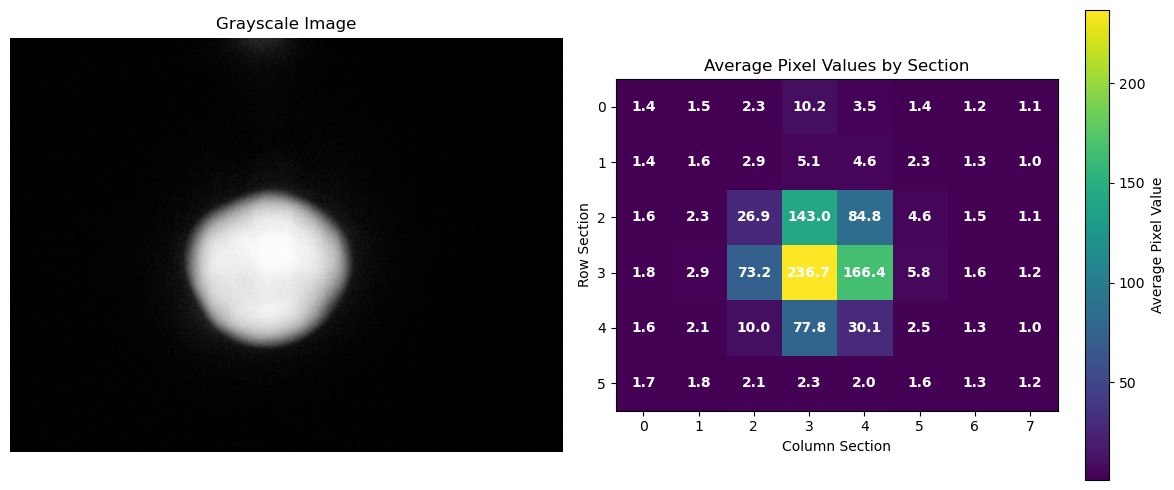

In [ ]:
fluo1 = cv.imread('../AwbOff470/img_full_0000.jpg')
# fluo1g = cv.cvtColor(fluo1, cv.COLOR_BGR2GRAY)
fluo1g = extract_g_channel(fluo1)
suback_fluog1 = subtract_background(fluo1g, background_model)
avg1g, max1g, _, _ = pixel_average_analysis(suback_fluog1, section_rows=6, section_cols=8)

In [69]:
print(f"Average: {avg1g} \nMax: {max1g}")

Average: 19.55633668648072 
Max: 236.7191739064167


Use on last image

Overall average pixel value: 3.40

Image dimensions: 2592 x 1944
Section size: 324 x 324
\Sectioned image analysis:
Min section average: 1.88
Max section average: 13.52
Standard deviation across sections: 2.59


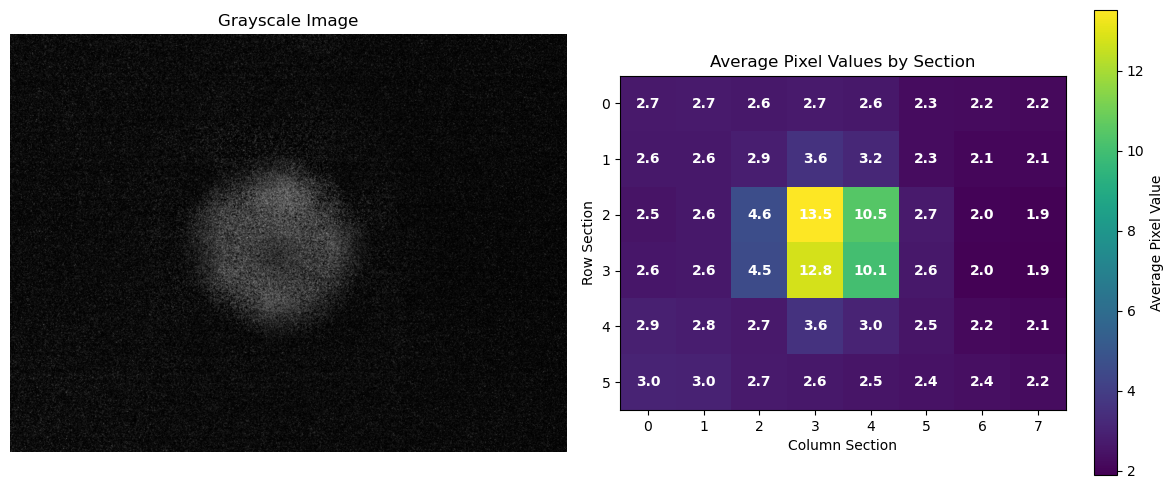

In [ ]:
fluo5 = cv.imread('../AwbOff470/img_full_0007.jpg')
# fluo5g = cv.cvtColor(fluo5, cv.COLOR_BGR2GRAY)
fluo5g = extract_g_channel(fluo5)
suback_fluog5 = subtract_background(fluo5g, background_model)
avg5g, max5g, _, _ = pixel_average_analysis(suback_fluog5, section_rows=6, section_cols=8)

### Perform on all images

In [ ]:
max_list = np.zeros(8)
static_list = np.zeros(8)

for i in range(0, 8):
    fluo = cv.imread(f'../AwbOff470/img_full_{i:04d}.jpg')
    # fluo_g = cv.cvtColor(fluo, cv.COLOR_BGR2GRAY)
    fluo_g = extract_g_channel(fluo)
    suback_fluog = subtract_background(fluo_g, background_model)
    avg, max_val, min_val, static_val = pixel_average_analysis(suback_fluog, section_rows=6, section_cols=8, static_row=3, static_col=3,verbose=False)
    print(f"Image {i}: Average: {avg:.2f}, Max: {max_val:.2f}, Min: {min_val:.2f}, Static: {static_val:.2f}")
    
    max_list[i] = max_val
    static_list[i] = static_val

Image 0: Average: 19.56, Max: 236.72, Min: 1.03, Static: 236.72
Image 1: Average: 18.23, Max: 184.96, Min: 1.26, Static: 184.96
Image 2: Average: 9.56, Max: 106.27, Min: 1.37, Static: 106.27
Image 3: Average: 5.67, Max: 60.50, Min: 1.43, Static: 60.50
Image 4: Average: 4.50, Max: 37.26, Min: 1.56, Static: 37.26
Image 5: Average: 4.49, Max: 30.25, Min: 1.82, Static: 30.25
Image 6: Average: 3.58, Max: 15.29, Min: 1.88, Static: 15.29
Image 7: Average: 3.40, Max: 13.52, Min: 1.88, Static: 12.76


Using maximum section averages

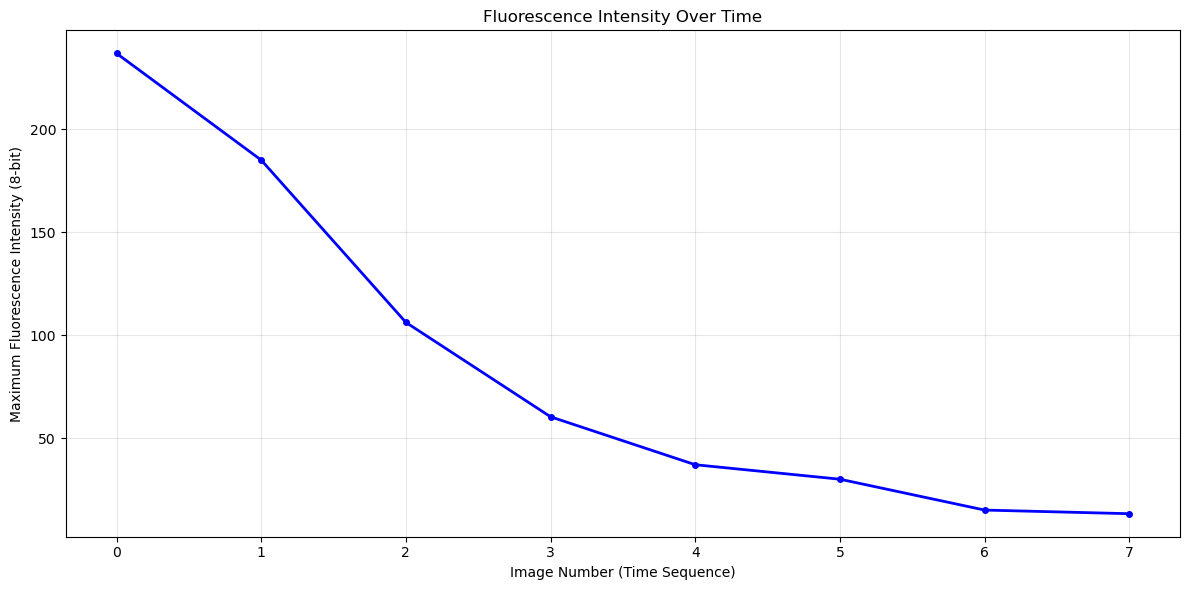

Min: 13.52
Max: 236.72
Range: 223.20


In [72]:
# Create the fluorescence intensity graph
plt.figure(figsize=(12, 6))

image_numbers = list(range(0, len(max_list)))

plt.plot(image_numbers, max_list, 'b-o', linewidth=2, markersize=4)
plt.xlabel('Image Number (Time Sequence)')
plt.ylabel('Maximum Fluorescence Intensity (8-bit)')
plt.title('Fluorescence Intensity Over Time')
plt.grid(True, alpha=0.3)

# mean_intensity = np.mean(max_list)
# std_intensity = np.std(max_list)
# plt.axhline(y=mean_intensity, color='r', linestyle='--', alpha=0.7, label=f'Mean: {mean_intensity:.2f}')
# plt.axhline(y=mean_intensity + std_intensity, color='orange', linestyle=':', alpha=0.7, label=f'+1σ: {mean_intensity + std_intensity:.2f}')
# plt.axhline(y=mean_intensity - std_intensity, color='orange', linestyle=':', alpha=0.7, label=f'-1σ: {mean_intensity - std_intensity:.2f}')

# plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
# print(f"\nFluorescence Intensity Statistics:")
# print(f"Mean: {mean_intensity:.2f}")
# print(f"Standard Deviation: {std_intensity:.2f}")
print(f"Min: {min(max_list):.2f}")
print(f"Max: {max(max_list):.2f}")
print(f"Range: {max(max_list) - min(max_list):.2f}")

Using static section averages

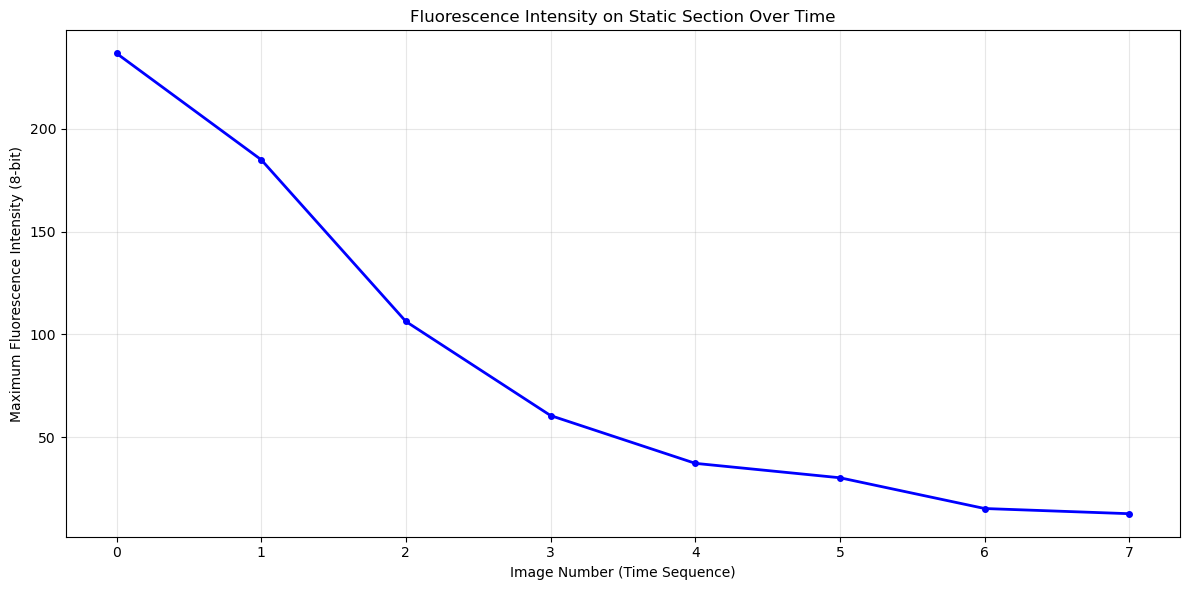

Min: 12.76
Max: 236.72
Range: 223.95


In [73]:
# Create the fluorescence intensity graph
plt.figure(figsize=(12, 6))

image_numbers = list(range(0, len(static_list)))

plt.plot(image_numbers, static_list, 'b-o', linewidth=2, markersize=4)
plt.xlabel('Image Number (Time Sequence)')
plt.ylabel('Maximum Fluorescence Intensity (8-bit)')
plt.title('Fluorescence Intensity on Static Section Over Time')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Min: {min(static_list):.2f}")
print(f"Max: {max(static_list):.2f}")
print(f"Range: {max(static_list) - min(static_list):.2f}")

## 4. Test on all fluorescent images (with bounding box ROI identification)

Found object with bounding box: x=750, y=617, width=930, height=886


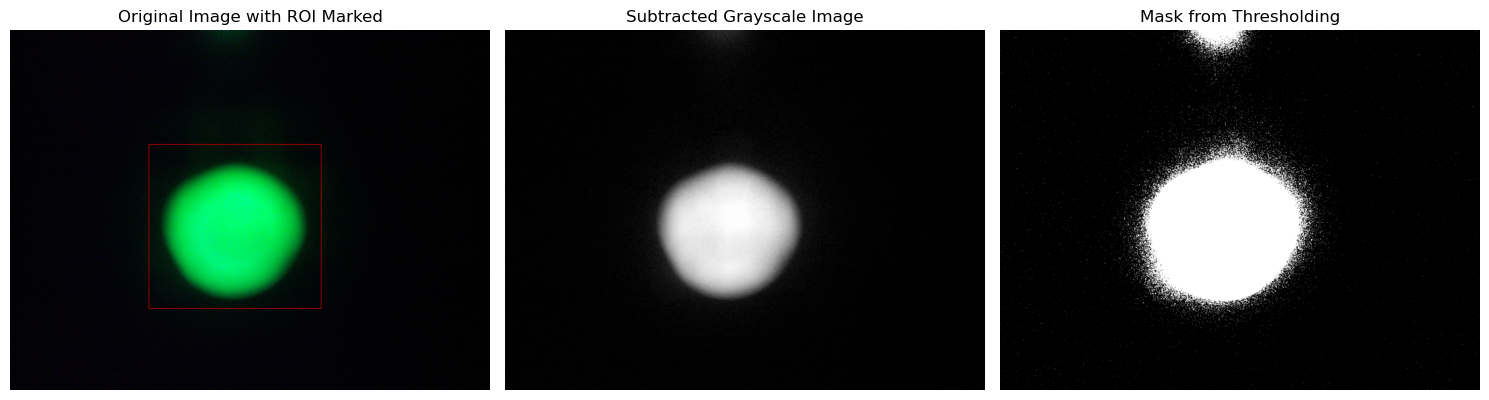

Overall average pixel value: 19.56

Image dimensions: 2592 x 1944
ROI area: Row: 750:1680, Column: 617:1503
ROI size: 930 x 886
\Pixel analysis:
Average pixel value at ROI: 239.14
Standard deviation at ROI: 9.78


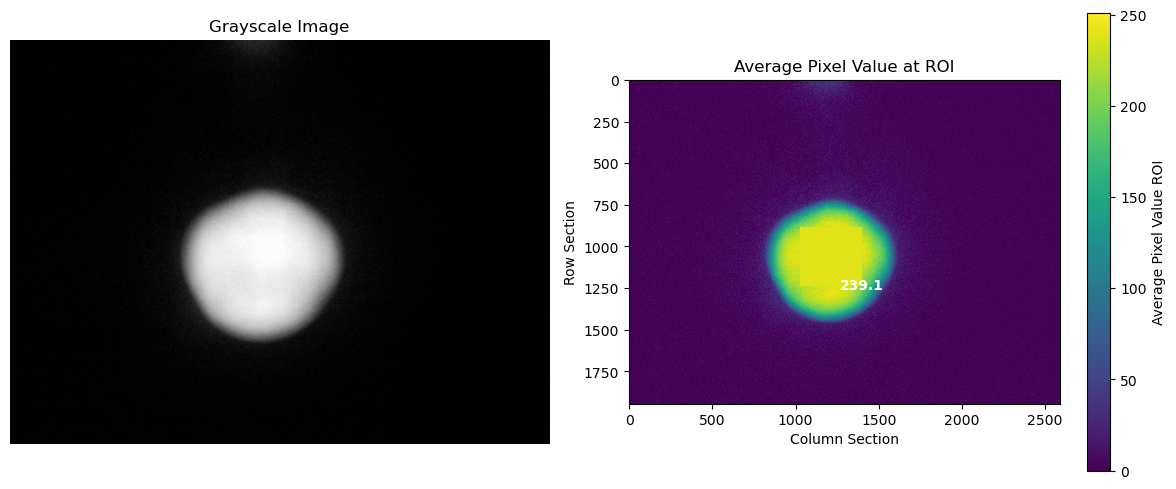

Overall average pixel value: 19.56
Average pixel value at ROI: 239.14


In [ ]:
fluo0 = cv.imread('../AwbOff470/img_full_0000.jpg')
# fluo0g = cv.cvtColor(fluo0, cv.COLOR_BGR2GRAY)
fluo0g = extract_g_channel(fluo0)
suback_fluog0 = subtract_background(fluo0g, background_model)

x, y, w, h = get_roi(fluo0, suback_fluog0, threshold_value=14, verbose=True)
overall_avg, average_at_roi = pixel_roi_analysis(suback_fluog0, x, y, w, h, subset=0.4)
print(f"Overall average pixel value: {overall_avg:.2f}")
print(f"Average pixel value at ROI: {average_at_roi:.2f}")

On last image

Found object with bounding box: x=949, y=652, width=497, height=380


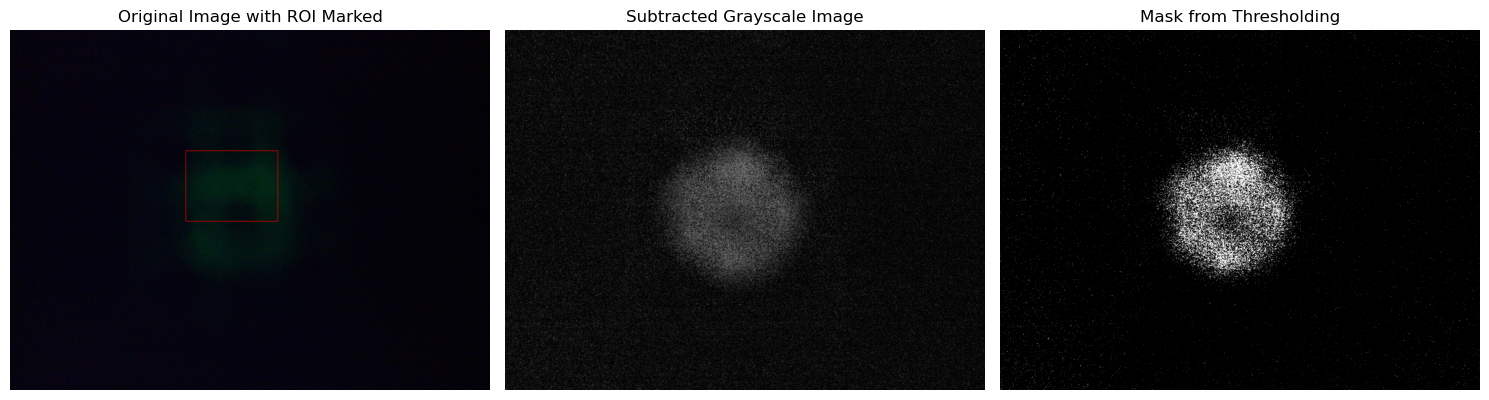

Overall average pixel value: 3.40

Image dimensions: 2592 x 1944
ROI area: Row: 949:1446, Column: 652:1032
ROI size: 497 x 380
\Pixel analysis:
Average pixel value at ROI: 15.87
Standard deviation at ROI: 6.24


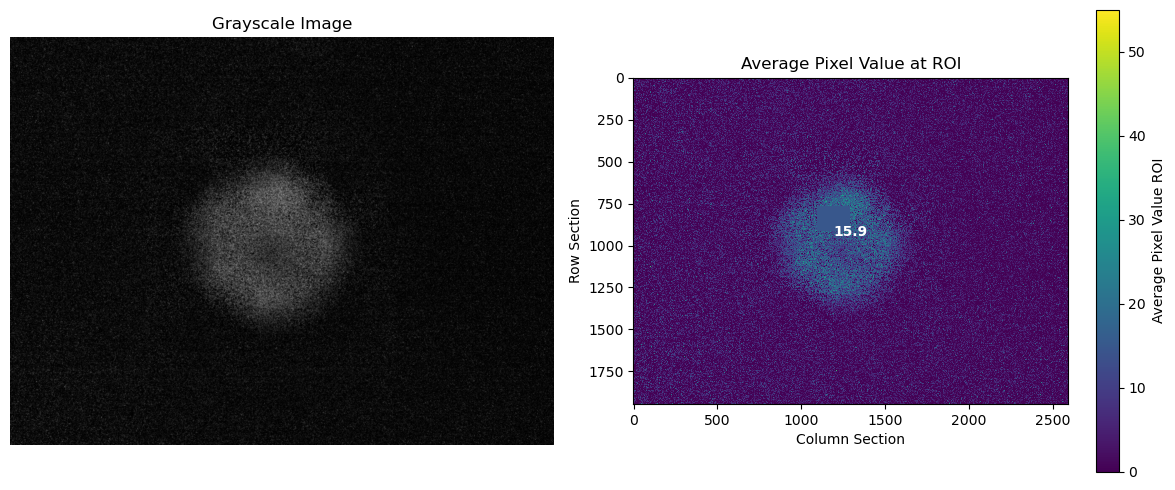

Overall average pixel value: 3.40
Average pixel value at ROI: 15.87


In [ ]:
fluo5 = cv.imread('../AwbOff470/img_full_0007.jpg')
fluo5g = extract_g_channel(fluo5)
suback_fluog5 = subtract_background(fluo5g, background_model)
x5, y5, w5, h5 = get_roi(fluo5, suback_fluog5, threshold_value=14, verbose=True)
overall_avg5, average_at_roi5 = pixel_roi_analysis(suback_fluog5, x5, y5, w5, h5, subset=0.4)
print(f"Overall average pixel value: {overall_avg5:.2f}")
print(f"Average pixel value at ROI: {average_at_roi5:.2f}")

Perform on all images

In [ ]:
avg_roi_arr = np.zeros(8)

for i in range(0, 8):
    fluo = cv.imread(f'../AwbOff470/img_full_{i:04d}.jpg')
    fluo_g = cv.cvtColor(fluo, cv.COLOR_BGR2GRAY)
    suback_fluog = subtract_background(fluo_g, background_model)

    x, y, w, h = get_roi(fluo, suback_fluog, threshold_value=14, verbose=False)
    overall_avg, average_at_roi = pixel_roi_analysis(suback_fluog, x, y, w, h, subset=0.4, verbose=False)
    print(f"Image {i}: Average: {overall_avg:.2f}, ROI average: {average_at_roi:.2f}")
    
    avg_roi_arr[i] = average_at_roi

Image 0: Average: 12.80, ROI average: 150.76
Image 1: Average: 12.23, ROI average: 118.70
Image 2: Average: 6.99, ROI average: 73.07
Image 3: Average: 4.74, ROI average: 43.17
Image 4: Average: 4.26, ROI average: 24.39
Image 5: Average: 4.56, ROI average: 20.92
Image 6: Average: 4.05, ROI average: 14.54
Image 7: Average: 3.92, ROI average: 13.65


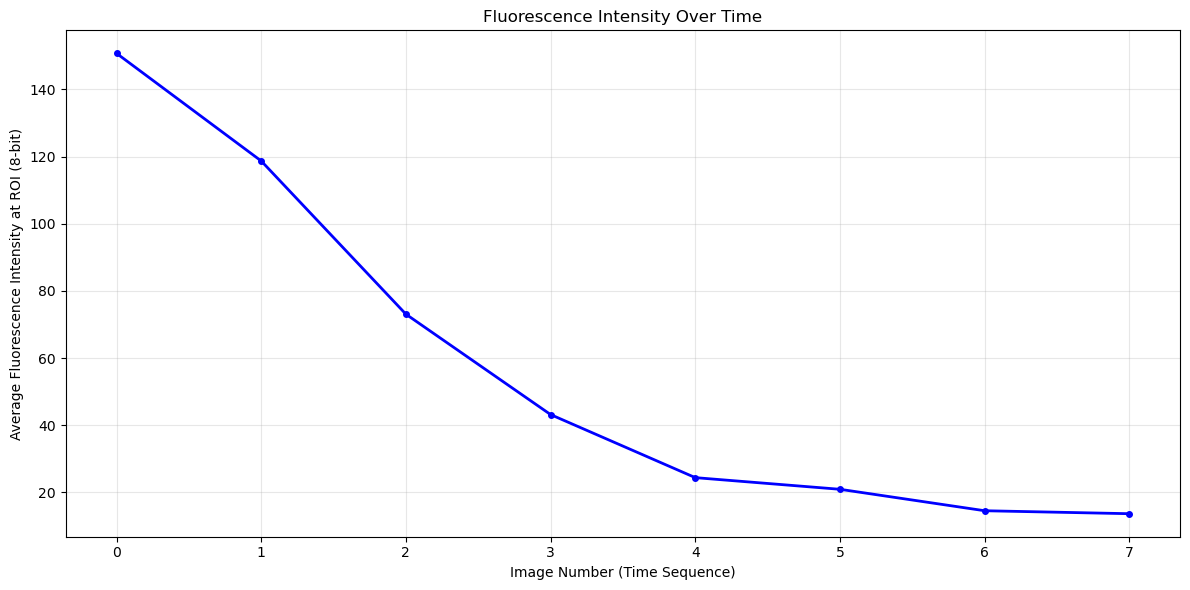

Min: 13.65
Max: 150.76
Range: 137.11


In [77]:
# Create the fluorescence intensity graph
plt.figure(figsize=(12, 6))

image_numbers = list(range(0, len(avg_roi_arr)))  

plt.plot(image_numbers, avg_roi_arr, 'b-o', linewidth=2, markersize=4)
plt.xlabel('Image Number (Time Sequence)')
plt.ylabel('Average Fluorescence Intensity at ROI (8-bit)')  # Also fixed label
plt.title('Fluorescence Intensity Over Time')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Also fix the summary statistics to use avg_roi_arr
print(f"Min: {min(avg_roi_arr):.2f}")
print(f"Max: {max(avg_roi_arr):.2f}")
print(f"Range: {max(avg_roi_arr) - min(avg_roi_arr):.2f}")